In [1]:
%matplotlib notebook

In [2]:
# Author: Proloy das <pd640@nmr.mgh.harvard.edu>
#
# License: BSD (3-clause)
import numpy as np
import eelbrain
import mne
from mne.datasets import sample
from codetiming import Timer
from matplotlib import pyplot as plt

from mayavi import mlab
mlab.init_notebook('png')
mne.viz.set_3d_backend('mayavi')

Notebook initialized with png backend.


In [3]:
data_path = sample.data_path()
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
ave_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
cov_fname = data_path + '/MEG/sample/sample_audvis-shrunk-cov.fif'
subjects_dir = data_path + '/subjects'
condition = 'Left Auditory'
subject = 'sample'

# Read noise covariance matrix
noise_cov = mne.read_cov(cov_fname)

## Simulate raw data

In [4]:
info = mne.io.read_info(ave_fname)
tstep = 1. / info['sfreq']
forward = mne.read_forward_solution(fwd_fname)
src = forward['src']

### Region to activate
To select a region to activate, we use the caudal middle frontal to grow a region of interest.

In [5]:
roi = 'caudalmiddlefrontal'
rois = ['transversetemporal', 'precentral']
selected_labels = [mne.read_labels_from_annot(subject, regexp=f'{roi}-lh',
                                            subjects_dir=subjects_dir)[0] for roi in rois]
location = 'center'  # Use the center of the region as a seed.
extent = 10.  # Extent in mm of the region.
labels = [mne.label.select_sources(
    subject, selected_label, location=location, extent=extent,
    subjects_dir=subjects_dir) for selected_label in selected_labels]

### Define the time course of the activity for each source of the region to activate.
Here we use a sine wave at 18 Hz with a peak amplitude of 10 nAm.

In [6]:
source_time_series1 = 5*np.sin(2. * np.pi * 18. * np.arange(100) * tstep) * 10e-9 + np.random.random(100) * 1e-11
source_time_series2 = np.sin(2. * np.pi * 16. * np.arange(100) * tstep) * 10e-9 + np.random.random(100) * 1e-11
source_time_serieses = (source_time_series1, source_time_series2)

### Define when the activity occurs using events. 
The first column is the sample of the event, the second is not used, and the third is the event id. Here the events occur every 200 samples.

In [7]:
n_events = 50
events = np.zeros((n_events, 3))
events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
events[:, 2] = 1  # All events have the sample id.

### Create simulated source activity.
Here we use a `SourceSimulator` whose add_data method is key. It specified where (label), what (source_time_series), and when (events) an event type will occur.

In [8]:
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
for label, source_time_series  in zip(labels, source_time_serieses):
    source_simulator.add_data(label, source_time_series, events)

### Project the source time series to sensor space and add some noise.
The source simulator can be given directly to the simulate_raw function.

In [9]:
raw = mne.simulation.simulate_raw(info, source_simulator, forward=forward)
raw.set_eeg_reference(projection=True)
cov = mne.make_ad_hoc_cov(raw.info)
mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])

<RawArray | 376 x 10000 (16.6 s), ~32.0 MB, data loaded>

### extract the epochs and form evoked object

<IPython.core.display.Javascript object>


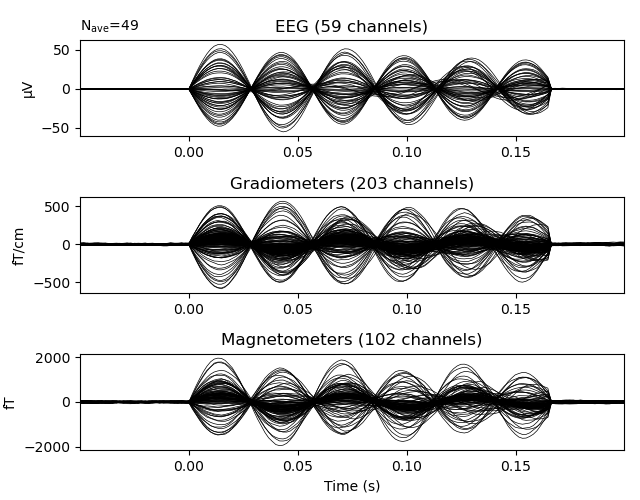

In [10]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2)
evoked = epochs.average()
fig = evoked.plot()

Crop timepoints of interest, and pick only the MEG channels

In [11]:
evoked.crop(tmin=0.00, tmax=0.15)

evoked = evoked.pick_types(eeg=False, meg=True)

## Handling forward solution

In [12]:
# forward = mne.read_forward_solution(fwd_fname)

In [13]:
add_distance = False
if add_distance is True:
    from mne.source_space import add_source_space_distances
    add_source_space_distances(forward['src'], np.inf, n_jobs=6)
    display(forward['src'][0]['dist'])
    mne.write_forward_solution(fwd_fname, forward, overwrite=True)    

In [14]:
def get_dist(forward, add_distance=False):
    from scipy import sparse
    if add_distance is True:
        from mne.source_space import add_source_space_distances
        add_source_space_distances(forward['src'], np.inf, n_jobs=6)
    def slice_dist(src):
        return src['dist'][src['inuse'].astype(bool)][:, src['inuse'].astype(bool)]
    dist = sparse.block_diag([slice_dist(src) for src in forward['src']])
    splits = [src['nuse'] for src in forward['src']]
    return dist, splits

In [15]:
# Run if the follwoing spacing is not available
# spacing = 'ico4'
# subject = 'sample'
# src = mne.setup_source_space(subject, spacing=spacing, add_dist=True,
#                              subjects_dir=subjects_dir, n_jobs=6)
# trans = data_path + "\\MEG\\sample\\sample_audvis_raw-trans.fif"
# bem = subjects_dir + "\\sample\\bem\\sample-5120-5120-5120-bem-sol.fif"
# fwd = mne.make_forward_solution(evoked.info, trans=trans, src=src, bem=bem,
#                                 meg=True, eeg=False, mindist=5.0, n_jobs=6,
#                                 verbose=True)
# fwd_fname = data_path + "\\MEG\\sample\\sample_audvis-meg-ico-4-fwd.fif"
# mne.write_forward_solution(fwd_fname, fwd, overwrite=True)    

In [16]:
forward

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

In [17]:
# Import the necessary private functions
from mne.inverse_sparse.mxne_inverse import \
    (_prepare_gain, is_fixed_orient,
     _reapply_source_weighting, _make_sparse_stc)

loose, depth = 0., 0.8  # corresponds to fixed orientation

all_ch_names = evoked.ch_names

# Handle depth weighting and whitening (here is no weights)
forward, gain, gain_info, whitener, source_weighting, mask = _prepare_gain(
    forward, evoked.info, noise_cov, pca=False, depth=depth,
    loose=loose, weights=None, weights_min=None, rank=None)

*ret, colorer = mne.cov.compute_whitener(noise_cov, info=evoked.info,
                                       return_colorer=True)

# Select channels of interest
sel = [all_ch_names.index(name) for name in gain_info['ch_names']]
M = evoked.data[sel]

# Whiten data
M = np.dot(whitener, M)

# Retrieve distance matrix
dist, splits = get_dist(forward)

In [18]:
display(dist)
display(splits)

<7498x7498 sparse matrix of type '<class 'numpy.float32'>'
	with 28103082 stored elements in COOrdinate format>

[3732, 3766]

In [19]:
display(M.shape)
display(gain.shape)
display(dist.shape)
display(dist.data.min())

(305, 91)

(305, 7498)

(7498, 7498)

0.0011254502

In [56]:
from purdonlabmeeg import (inspect_order, Handler, 
                           GammaExpGPKernel, MaternGPKernel,
                            MaternGPKernel2, SquaredExponentailGPKernel)
from scipy import linalg

r = np.eye(M.shape[0])  # whitened data

gpkernel = SquaredExponentailGPKernel(dist=dist, 
                                      fixed_params={'sigma_s': np.sqrt(0.99)},
                                      splits=splits)

# gpkernel = GammaExpGPKernel(dist=dist,
#                             fixed_params={'gamma': 2.5,
#                                           'sigma_s': np.sqrt(1)},
#                             splits=splits)

# gpkernel = MaternGPKernel(dist=dist, 
#                           fixed_params={'sigma_s': np.sqrt(1.)},
#                           splits=splits)

# gpkernel = MaternGPKernel2(dist=dist, 
#                           fixed_params={'sigma_s': np.sqrt(1.)},
#                           splits=splits)

class spclList(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __enter__(self):
        return self
    
    def __exit__(self, type, value, traceback):
        return True

M = M - M.mean(axis=1)[:, None]
u, s, vh = linalg.svd(M)
rel_tol = 0.01  # in percent


def fit_model(n_factors, order, method):
    # n_factors, n_channels, n_sources, n_samples, order
    handler = Handler(n_factors, M.shape[0], gain.shape[-1], M.shape[-1],
                      order)
#     spatial_maps = np.hstack((u[:,:n_factors] * s[:n_factors][None, :],
#                              (u[:,n_factors:s.shape[0]] * s[n_factors:][None, :]).sum(axis=1)[:,None])).T
    spatial_maps = (u[:,:n_factors] * s[:n_factors][None, :]).T
    scale = np.sqrt((spatial_maps * spatial_maps).sum(axis=1)
             / spatial_maps.shape[1])
    spatial_maps /= scale[:, None]
    spatial_maps += 0.1 * np.random.randn(*spatial_maps.shape)
#     x = spatial_maps.dot(M)
    x, *_ = linalg.lstsq(spatial_maps.T, M)
    thetas = np.log(.005) * np.ones(n_factors)  # 10mm2 acivity for detectable MEEG signal
    sigma_ws = [gpkernel.cov(theta=theta) for theta in thetas]
    handler.a_upper.flat[::n_factors * order+1] = 1.
#     handler.initialize_spatial_map(thetas, gpkernel, spatial_maps)
#     handler.expectation_wrt_w(gain, r)
    handler.initialize_sensor_map(thetas, gpkernel, r, spatial_maps)
#     import ipdb; ipdb.set_trace()
#     handler.q_upper[:] = 1e-2*np.eye((n_factors))
    res = x[:, :-1] - x[:, 1:]
    q_upper = res.dot(res.T) / res.shape[0]
    handler.q_upper[:] = q_upper
    initial_cond = np.zeros(n_factors * order)
    lls = []
    rel_changes = []
    do_break = False
    try:
        for j in range(100):
            print(f"iter {j}")
            ll1 = handler.update_timecources(M, r, initial_cond)
            ll2 = handler.update_spatial_map(M, gain, r)
            ll3 = handler._free_energy(M, gain, r)
            ll = ll1 + ll3 + ll2
            print(f"after time-course update: {ll1}")
            print(f"after spatial-map update: {ll2}")
            print(f"after spatial-map update: {ll3}")
            lls.append(ll)
            print(f"after total update: {ll}")
            if j > 5:
                try:
                    if do_break and rel_changes[-1] < rel_tol:
                        print(f'converged after iter: {j} at free energy: {ll}')
                        break
                except IndexError:
                    pass
            handler.update_time_dynamics(method)
            if j % 1 == 0:
#                 handler.update_spatial_scale(gain, r, tol=1e-4)
                try:
                    if rel_changes[-1] < rel_tol:
                        do_break = True
                except IndexError:
                    pass
            handler.expectation_wrt_w(gain, r)
#             ll = handler.free_energy(M, gain, r)
            try:
                rel_change = 100 * (lls[-1] - lls[-2]) / np.abs(lls[-2])
                rel_changes.append(rel_change)
            except IndexError:
                pass
#             initial_cond[:] = handler.xs[1][0]
    except KeyboardInterrupt:
        pass
    return handler, lls

In [57]:
with Timer(name="context manager"):
    handler, lls = fit_model(2, 2, 'NS')

iter 0
after time-course update: -5116.41567703319
after spatial-map update: -150980.00530012578
after spatial-map update: -787.8201837050274
after total update: -156884.24116086398
iter 1
after time-course update: -4890.695703227529
after spatial-map update: -150511.84544121966
after spatial-map update: -1045.1272623442237
after total update: -156447.6684067914
iter 2
after time-course update: -4930.41859612503
after spatial-map update: -147956.81397560617
after spatial-map update: -1210.7756521865213
after total update: -154098.0082239177
iter 3
after time-course update: -5024.554317675457
after spatial-map update: -145614.4541315755
after spatial-map update: -1292.6977189884528
after total update: -151931.7061682394
iter 4
after time-course update: -5154.670833747175
after spatial-map update: -140003.58300150183
after spatial-map update: -1376.9735111384198
after total update: -146535.22734638743
iter 5
after time-course update: -5328.935462447678
after spatial-map update: -128178.5

<IPython.core.display.Javascript object>


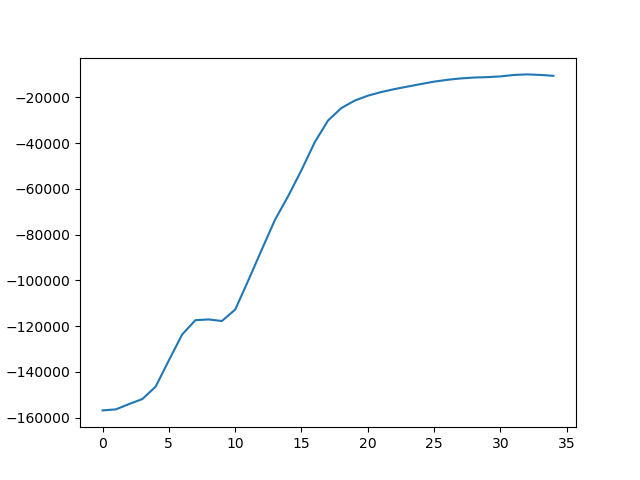

In [58]:
fig, ax = plt.subplots()
ax.plot(lls)

In [23]:
# t1 = Timer(name="with toarray()")
# t2 = Timer(name="without toarray()")

# for _ in range(10):
#     with t1:
#         from scipy import sparse
#         mat = np.exp(- gpkernel._dist/ 0.001)
#         out = sparse.csr_matrix((mat, *gpkernel._csrargs),
#                           (gpkernel.ndim, gpkernel.ndim))
#         out = out.toarray()
#         out = gpkernel._add_eye(out)
#         eu, vu = linalg.eigh(out[:out.shape[0]//2,:out.shape[0]//2])
#         el, vl = linalg.eigh(out[out.shape[0]//2:,out.shape[0]//2:])
#         v = linalg.block_diag(vu, vl)
#         e = np.hstack((eu, el))
# #         e, v = linalg.eigh(out)
# #         T, Z = linalg.schur(out, output='complex')
# from purdonlabmeeg._spatial_map_utils._scale_update import cg_solver
# for _ in range(5):
#     w = np.random.randn(sum(splits))
#     with t1:
#         k = gpkernel.cov(theta=np.log(.003))
#         y1 = cg_solver(k, w)
#     with t2:
#         kinv, k, _ = gpkernel.inv_cov(theta=np.log(.003))
#         y2 = kinv.dot(w)
#     print(np.allclose(y1, y2))

In [24]:
# ws = _reapply_source_weighting(ws, source_weighting, active_set)
vertices = [src['vertno'] for src in forward['src']]
voi = labels[0].center_of_mass(subject='sample', subjects_dir=subjects_dir, restrict_vertices=src)
ks = [gpkernel.cov(theta=np.log(scale))[np.where(vertices[0] == voi)[0][0]] for scale in (0.01, 0.005, .0015, 0.003)]
stcs = [mne.SourceEstimate(k, vertices, 0.0, 0.0) for k in ks]


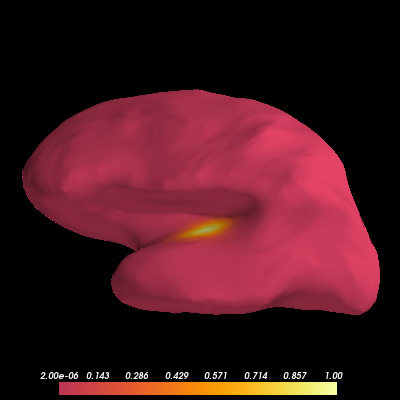

In [25]:
stcs[0].plot(subject='sample', surface='inflated', hemi='lh', colormap='inferno', views=['lateral'],
             subjects_dir=subjects_dir, size=(400, 400), clim=dict(kind='value', lims=(2e-6, 1e-4, 1)))


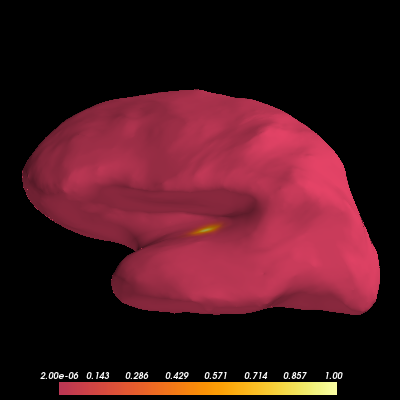

In [26]:
stcs[1].plot(subject='sample', surface='inflated', hemi='lh', colormap='inferno', views=['lateral'],
             subjects_dir=subjects_dir, size=(400, 400), clim=dict(kind='value', lims=(2e-6, 1e-4, 1)))


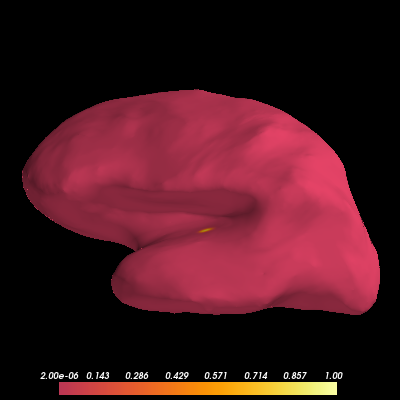

In [27]:
stcs[2].plot(subject='sample', surface='inflated', hemi='lh', colormap='inferno', views=['lateral'],
             subjects_dir=subjects_dir, size=(400, 400), clim=dict(kind='value', lims=(2e-6, 1e-4, 1)))


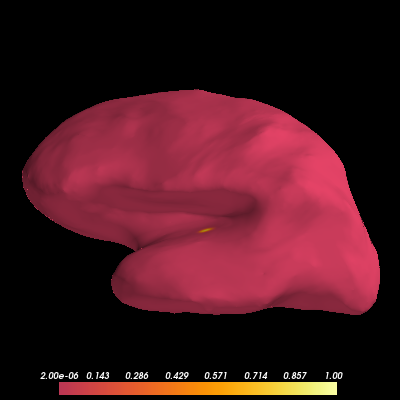

In [28]:
stcs[2].plot(subject='sample', surface='inflated', hemi='lh', colormap='inferno', views=['lateral'],
             subjects_dir=subjects_dir, size=(400, 400), clim=dict(kind='value', lims=(2e-6, 1e-4, 1)))

In [29]:
handler.fw_upper.shape

(305, 2)

In [59]:
display(handler.a_upper)

array([[ 2.00619894,  0.81259716, -1.0062902 , -0.81104587],
       [-0.04128246,  1.95831574,  0.04129218, -0.95848755]])

In [60]:
display(handler.q_upper)

array([[ 9.33098740e-07, -1.03140352e-07],
       [-1.03140352e-07,  1.14016100e-08]])

In [61]:
display(np.exp(handler.thetas))

array([0.005, 0.005])

<IPython.core.display.Javascript object>


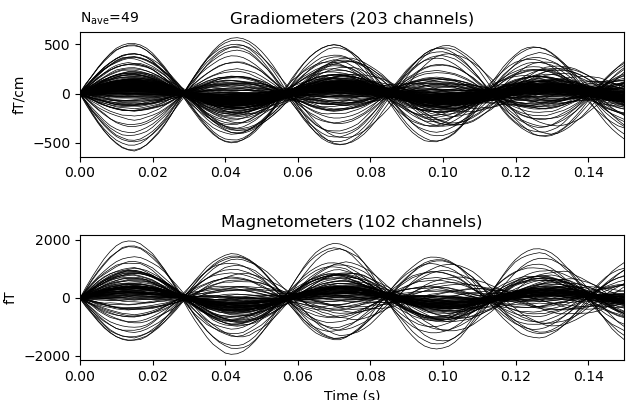

In [62]:
fig = evoked.plot()

<IPython.core.display.Javascript object>


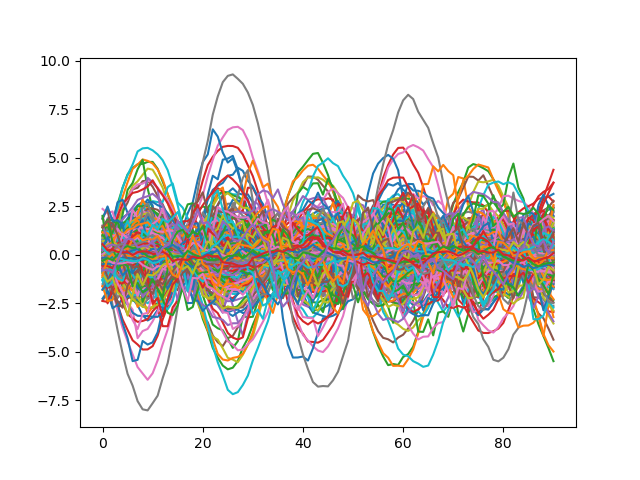

In [63]:
fig, ax = plt.subplots()
im = ax.plot(M.T)

<IPython.core.display.Javascript object>


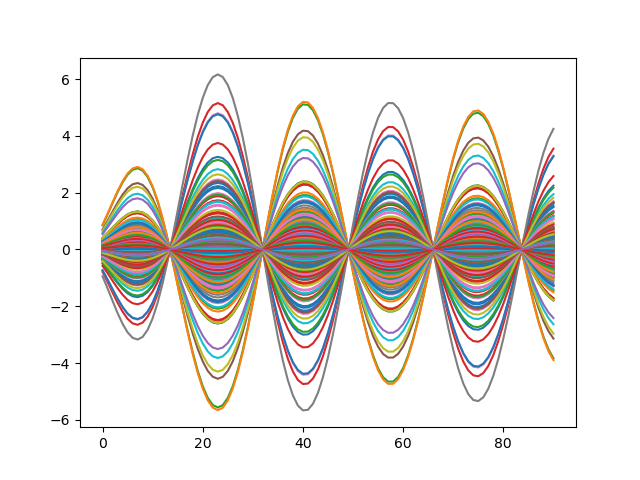

In [64]:
fig, ax = plt.subplots()
im = ax.plot((handler.fw_[:,0:1].dot(handler.xs[1][:,0:1].T).T))

<IPython.core.display.Javascript object>


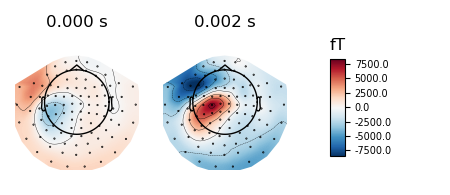

In [65]:
spatial_map = mne.EvokedArray(colorer.dot(handler.fw_upper), evoked.info, tmin=0,
                               nave=1, comment='spatial_maps')
times = np.arange(handler.n_factors) / evoked.info['sfreq']
fig = spatial_map.plot_topomap(times, ch_type='mag', time_unit='s')

<IPython.core.display.Javascript object>


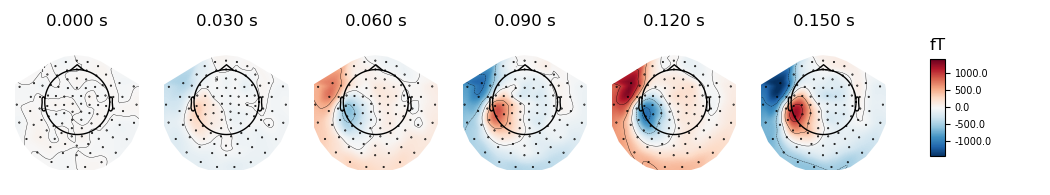

In [66]:
times = np.linspace(0, 0.15, 6) 
# times = np.arange(handler.n_factors) / evoked.info['sfreq']
fig = evoked.plot_topomap(ch_type='mag', time_unit='s', times=times)

In [67]:
time_courses = [mne.EvokedArray(np.dot(colorer.dot(handler.fw_upper)[:, i][:, None], handler.xs[1][:,i][None, :]), evoked.info,
                                tmin=evoked.tmin, nave=1, comment=f'spatial map-{i}') for i in range(handler.n_factors)]

<Evoked | 'spatial_maps' (average, N=1), [0, 0.14985] sec, 305 ch, ~3.4 MB>


<IPython.core.display.Javascript object>


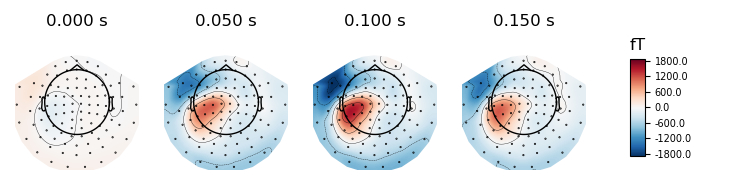

In [68]:
spatial_map = mne.EvokedArray(np.dot(colorer.dot(handler.fw_upper)[:, :], handler.xs[1][:,:handler.n_factors].T), evoked.info,
                              tmin=evoked.tmin, nave=1, comment='spatial_maps')
print(spatial_map)
# times = [0.000,]
fig = spatial_map.plot_topomap(ch_type='mag', time_unit='s')

In [69]:
active_set = np.ones(handler.n_sources, dtype=np.bool)
ws = handler.ws.copy().T
sigma_ws = handler.sigma_ws.copy()
masks = [np.sqrt(M.shape[1]) * np.abs(ws[:, i] / np.sqrt(np.diag(sigma_ws[i]))) for i in range(handler.n_factors)]
ws = _reapply_source_weighting(ws, source_weighting, active_set)
sigma_ws = handler.sigma_ws.copy()
# display(forward['src'][0].keys())
vertices = [src['vertno'] for src in forward['src']]
stcs = [mne.SourceEstimate(ws[:, i], vertices, 0.0, 0.0) for i in range(handler.n_factors)]
masked_stcs = [mne.SourceEstimate(ws[:,i] * (masks[i] > 3.4), vertices, 0.0, 0.0) for i in range(handler.n_factors)]

In [70]:
masks[0].min()

5.6572689024225614e-05

In [71]:
mlab.init_notebook('png')

Notebook initialized with png backend.


<IPython.core.display.Javascript object>


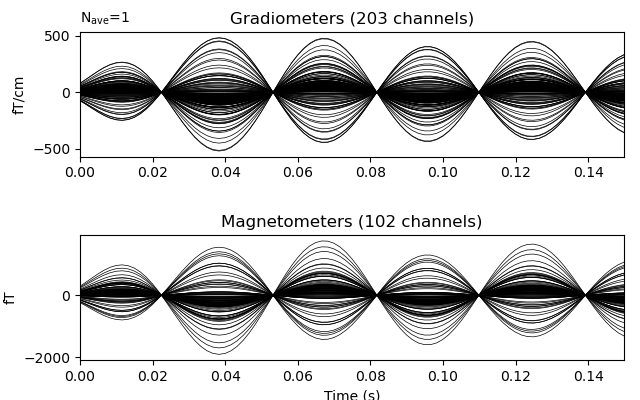

In [72]:
fig = time_courses[0].plot()


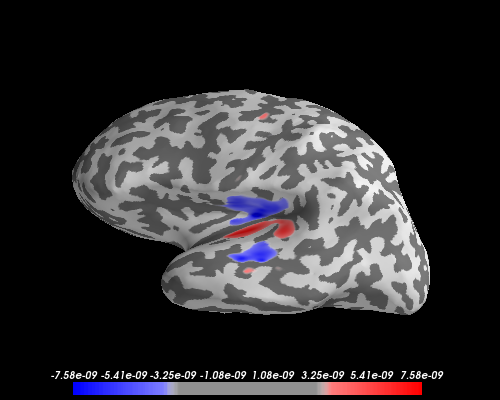


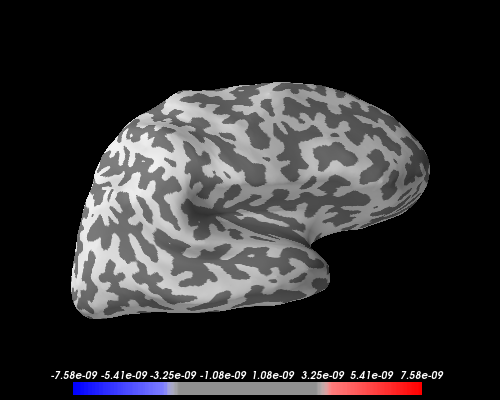


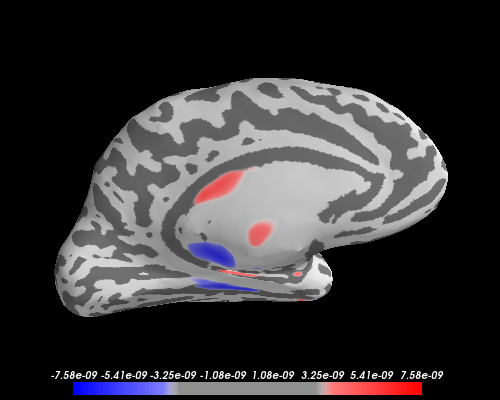


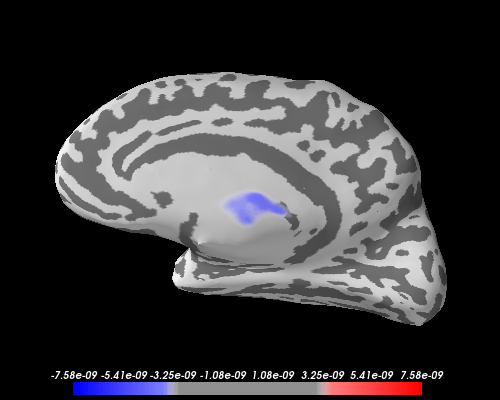

In [83]:
stcs[0].plot(subject='sample', surface='inflated', hemi='split', colormap='bwr', views=['lateral', 'medial',],
             subjects_dir=subjects_dir, size=(1000, 800),) #clim=dict(kind='value', pos_lims=(2e-10, 5e-10, 2e-9)))

<IPython.core.display.Javascript object>


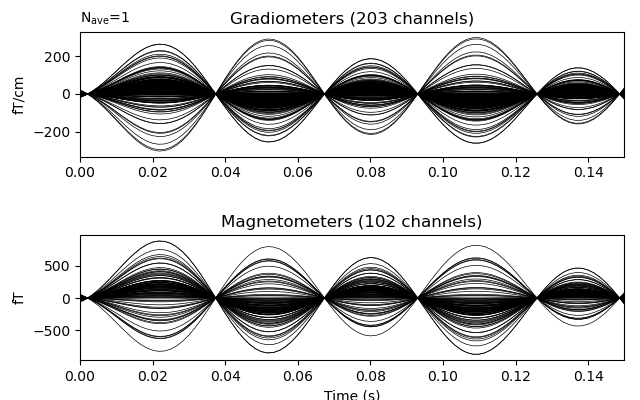

In [74]:
fig = time_courses[1].plot()


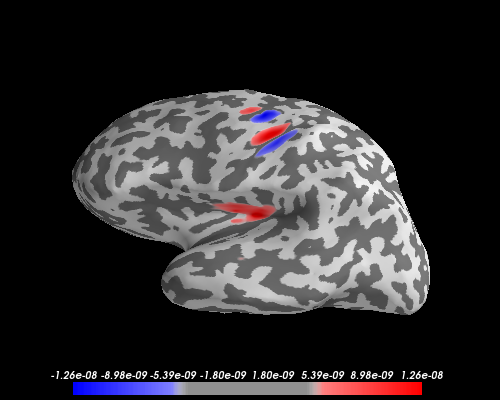


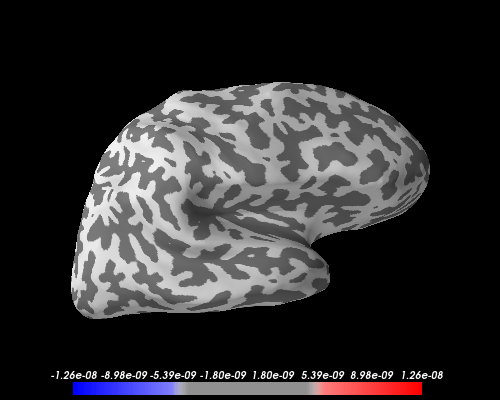


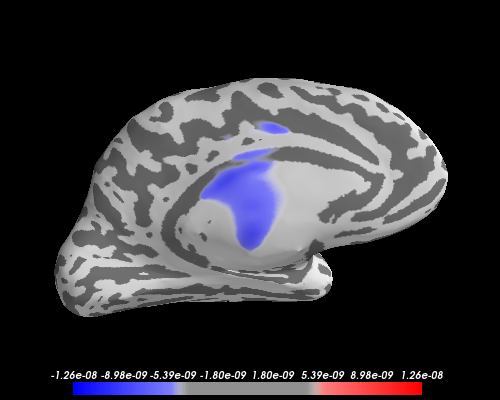


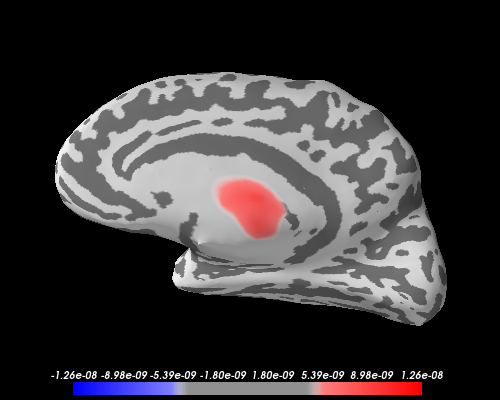

In [75]:
stcs[1].plot(subject='sample', surface='inflated', hemi='split', colormap='bwr', views=['lateral', 'medial',],
             subjects_dir=subjects_dir, size=(1000, 800)) #, clim=dict(kind='value', pos_lims=(2e-10, 5e-10, 2e-9)))

In [76]:
true_stc = source_simulator.get_stc(start_sample=100, stop_sample=200)
true_stc.data **=2
true_stc = true_stc.sum().sqrt()


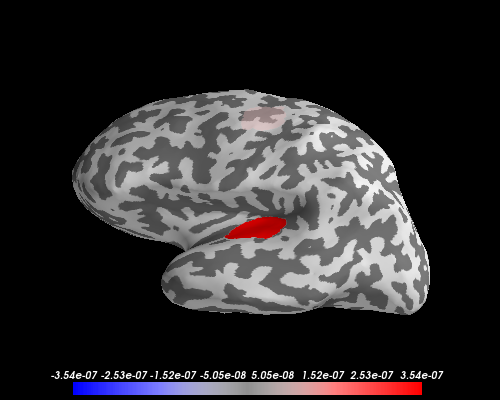


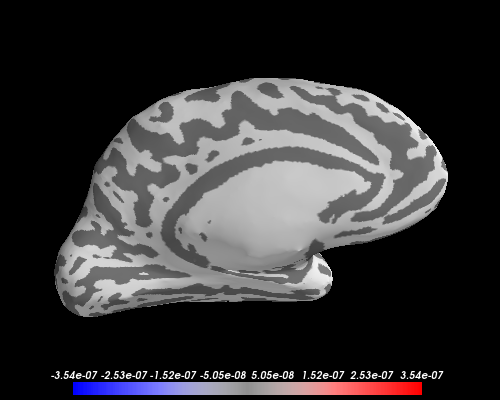

In [77]:
true_stc.plot(subject='sample', surface='inflated', hemi='lh', colormap='bwr', views=['lateral', 'medial',],
             subjects_dir=subjects_dir, size=(500, 800))

In [78]:
# %matplotlib inline
# from purdonlabmeeg._latent_dynamics import test_handler3
# test_handler3()

In [79]:
np.exp(handler.thetas)

array([0.005, 0.005])

In [80]:
# from eelbrain import save
# save.pickle(handler, '.test.pkl')

In [81]:
# from eelbrain import load
# handler = load.unpickle('.test.pkl')

In [82]:
%debug

> c:\users\prolo\miniconda3\envs\eelbrain\lib\site-packages\ipython\core\compilerop.py(100)ast_parse()
     98         Arguments are exactly the same as ast.parse (in the standard library),
     99         and are passed to the built-in compile function."""
--> 100         return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
    101 
    102     def reset_compiler_flags(self):

--KeyboardInterrupt--
ipdb> q
